# Homework Problem: Anthony Smith (Aiyagari Economy)
## Jincheng(Eric) Huang

There is a measure one of consumers and a typical consumer solves:
$$
v(k, \epsilon ; \overline{k})=\max _{k^{\prime}}\left[U\left(r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right)+\beta E_{\epsilon^{\prime} | \epsilon} v\left(k^{\prime}, \epsilon^{\prime} ; \overline{k}\right)\right]
$$
    subject to $k' \geq 0$, where $k$ is individual capital, $\bar{k}$ is aggregate capital and $\epsilon$ is the consumer's employment status: $\epsilon \in \{\epsilon_1, \epsilon_2\}$, with $\epsilon_1 = 1$ (employed) and $\epsilon_2 = 0$ (unemployed).

## 1. Characterizing Equations
The FOC of the consumer's problem is:
$$
-U'\left(r(\overline{k})+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right) + 
\beta E_{\epsilon' | \epsilon} v_{k'}\left(k',\epsilon';\overline{k} \right) = 0
$$
The envelope condition is:
$$
v_k (k,\epsilon,\overline{k}) = U'\left(r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right)
\left(r(\overline{k})+1-\delta \right)
$$

Combining yields the intertemporal Euler equation:
$$
U'\left(r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}\right) = 
\beta E_{\epsilon' | \epsilon} U'\left(r(\overline{k'})k'+w(\overline{k'}) \epsilon'+(1-\delta) k'-k'^{\prime}\right)
\left(r(\overline{k'})+1-\delta \right)
$$

## 2. Solve for Policy Functions
The pricing functions $r(\overline{k})=\alpha \overline{k}^{\alpha-1}(1-u)^{1-\alpha}$ and $w(\overline{k})=(1-\alpha) \overline{k}^{\alpha}(1-u)^{-\alpha}$, where aggregate labor supply is equal to $1-u$.

Let a period be one year and set $u(c) = \log(c), \beta=0.96, \delta=0.06$, and $\alpha=0.36$.

Given the utility function above, the intertemporal Euler equation can be expressed as:
$$
1/c(\epsilon,\bar{k}) = \beta \left(r(\overline{k'})+1-\delta \right) E_{\epsilon' | \epsilon} \left[ 1/ c'(\epsilon',\bar{k'}) \right]
$$
where 
$$ 
c(\epsilon,\bar{k}) = r(\overline{k})k+w(\overline{k}) \epsilon+(1-\delta) k-k^{\prime}
$$
and
$$
c'(\epsilon',\bar{k'}) = r(\overline{k'})k'+w(\overline{k'}) \epsilon'+(1-\delta) k'-k'^{\prime}
$$

Therefore
$$
c(\epsilon,\bar{k}) =  1/ \left[\beta \left(r(\overline{k'})+1-\delta \right) E_{\epsilon' | \epsilon} 1/\left(r(\overline{k'})k'+w(\overline{k'}) \epsilon'+(1-\delta) k'-k'^{\prime}\right) \right]
$$

I use the endogenous grid method from Carroll (2006) to calculate the policy function below.

In [1]:
import numpy as np
from scipy.optimize import fsolve,bisect
from scipy import interpolate
import matplotlib.pyplot as plt
from numba import njit

In [2]:
@njit
def r(α,k,u):
    return α*k**(α-1)*(1-u)**(1-α)

@njit
def w(α,k,u):
    return (1-α)*k**(α)*(1-u)**(-α)

@njit
def u(c):
    return np.log(c)

uprime = lambda c: 1/c

# The Euler equation corresponding to the form written above
def Euler_solve_c(functions,parameters,states,klevels):
    gc = functions
    α,β,δ,ur = parameters
    iϵ,k_grid,ϵ_states,ϵ_P = states
    kp,k_bar,kbarp = klevels
    
    ikp = np.where(k_grid==kp)[0]
    nk, nϵ = len(k_grid), len(ϵ_states)
    
    E_Ucp = 0
    for iϵp,ϵp in enumerate(ϵ_states):
        E_Ucp = E_Ucp + ϵ_P[iϵ,iϵp] * 1/(gc[iϵp*nk+ikp])
    c = 1/(β*(r(α,kbarp,ur)+1-δ)*E_Ucp)
    return c

# The Endogenous Grid Method to solve for policy and value functions
def EGM(parameters,states):
    α,β,δ,ur = parameters
    k_grid,k_bar,ϵ_states,ϵ_P = states
    
    nk,nϵ = len(k_grid),len(ϵ_states)
    gc = r(α,k_bar,ur)*np.ones((nϵ,1)).dot(k_grid.reshape(1,nk)).reshape(nϵ*nk,)
    gk = np.zeros(nϵ*nk,)
    V = np.zeros(nϵ*nk,)
    max_diff = np.inf
    tol = 1e-6
    niter = 1
    
    print('EGM for policy function:')
    
    while max_diff > tol:
        # A vector for expected continuation value. Each capital value stands for k'
        ev = np.zeros((nϵ*nk,))
        for ikp in range(nk):
            idxp = np.arange(ikp,nϵ*nk+ikp,nk)
            for iϵ in range(nϵ):            
                idx = iϵ*nk + ikp 
                ev[idx] = ev[idx] + ϵ_P[iϵ,:].dot(V[idxp])
        
        c_end, k_end, V_end, V_new = np.zeros(nϵ*nk,), np.zeros(nϵ*nk,), np.zeros(nϵ*nk,), np.zeros(nϵ*nk,)
        
        for iϵ,ϵ_val in enumerate(ϵ_states):
            grid_range = np.arange(iϵ*nk,iϵ*nk+nk,1)
            k0 = -np.inf
            for ikp,kp in enumerate(k_grid):
                idxp = iϵ*nk + ikp 
                c = Euler_solve_c((gc),(α,β,δ,ur),(iϵ,k_grid,ϵ_states,ϵ_P),(kp,k_bar,k_bar))
                k = (c+kp-w(α,k_bar,ur)*ϵ_val)/(r(α,k_bar,ur)+1-δ)
                if ikp == 0:
                    k0 = k 
                c_end[idxp] = c
                k_end[idxp] = k
                V_end[idxp] = u(c) + β*ev[idxp]
            
            k_interp_range = np.where(k_grid>k0)[0]
            V_end_interp = interpolate.interp1d(k_end[grid_range],V_end[grid_range],fill_value='extrapolate')
            gc_interp = interpolate.interp1d(k_end[grid_range],c_end[grid_range],fill_value='extrapolate')
            
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik
                
                if k in k_grid[k_interp_range]: 
                    gc[idx] = gc_interp(k)
                    V_new[idx] = V_end_interp(k)
                else:
                    gc[idx] = r(α,k_bar,ur)*k + w(α,k_bar,ur)*ϵ_val + (1-δ)*k
                    V_new[idx] = u(gc[idx]) + β*ev[iϵ*nk]
                    
                gk[idx] = r(α,k_bar,ur)*k + w(α,k_bar,ur)*ϵ_val + (1-δ)*k - gc[idx]

        max_diff = max(np.abs(V_new-V))
        V = V_new.copy()
        
        if niter == 1 or niter % 50 == 0:
            print('   Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
        
    return V,gk

# The value function iteration method to solve for policy and value functions
def VFI(α,β,δ,ur,k_grid,k_bar,ϵ_states,ϵ_P):
    
    
    nk = len(k_grid)
    nϵ = len(ϵ_states)
    gk = np.ones((nϵ,1)).dot(k_grid.reshape(1,nk)).reshape(nϵ*nk,)
    V = np.zeros(nϵ*nk,)
    max_diff = np.inf
    tol = 1e-6
    niter = 1
    
    while max_diff > 1e-6:
        # A vector for expected continuation value. Each capital value stands for k'
        ev = np.zeros((nϵ*nk,))
        for ikp in range(nk):
            idxp = np.arange(ikp,nϵ*nk+ikp,nk)
            for iϵ in range(nϵ):            
                idx = iϵ*nk + ikp 
                ev[idx] = ev[idx] + ϵ_P[iϵ,:].dot(V[idxp])
                
        V_new = np.zeros(nϵ*nk,)
        
        for iϵ,ϵ_val in enumerate(ϵ_states):
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik
                
                if niter % 5 == 1 :
                    vv = -np.inf
                    for ikp,kp in enumerate(k_grid):
                        idxp = iϵ*nk + ikp
                        c = r(α,k_bar,ur)*k + w(α,k_bar,ur)*ϵ_val + (1-δ)*k - kp
                        if c<=0:
                            break
                        else:
                            value = u(c) + β*ev[idxp]
                            if value > vv:
                                vv = value
                                gk[idx] = kp
                                V_new[idx] = value
                else:
                    kp = gk[idx]
                    idxp = iϵ*nk + np.where(k_grid==kp)[0]
                    c = r(α,k_bar,ur)*k + w(α,k_bar,ur)*ϵ_val + (1-δ)*k - kp 
                    V_new[idx] = u(c) + β*ev[idxp]
        
        max_diff = max(np.abs(V_new-V))
        V = V_new.copy()
        
        if niter == 1 or niter % 50 == 0:
            print('   Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
    return V,gk

In [3]:
# Model parameters
β = .96
δ = .06
α = .36
nk = 200
ur_ss = .1      # target unemployment rate at 10%
ϵ_ee = .9       # probability of staying employed in the next period

# Functions for calibration
def calculate_ur_ss(ϵ_uu,ϵ_ee):
    P = np.array([[ϵ_uu,1-ϵ_uu],[1-ϵ_ee,ϵ_ee]])
    mu = np.array([.5,.5])
    diff = np.inf
    
    while diff > 1e-8:
        mu_new = mu.dot(P)
        diff = max(np.abs(mu_new-mu))
        mu = mu_new.copy()
        
    return mu[0]

# Calibrate the probability of staying unemployed to match the unemployment rate target
ϵ_uu = fsolve(lambda ϵ_uu,ϵ_ee: calculate_ur_ss(ϵ_uu,ϵ_ee)-ur_ss,.1,args=(ϵ_ee))
ϵ_states = np.array([0.,1.])
ϵ_P = np.array([[ϵ_uu,1-ϵ_uu],[1-ϵ_ee,ϵ_ee]])
nϵ = len(ϵ_states)

# Generate a grid for capital
k_grid = np.linspace(0.001,40,nk).reshape(nk,)

## 3. Solve for the Steady State Distribution
Now that I have the policy function, I use the following steps to calculate the steady state:
1. Guess on $\overline{k}$, the aggregate capital level. Here I use the capital level from the representative-agent economy.
2. Use the policy function and the law of motion for $\epsilon$ to calculate the state transition matrix $P(k_i \epsilon_j,k_m \epsilon_n)$.
3. Find the invariant distribution $\mu(k,\epsilon)$ associated with the transition matrix.
4. Integrate each capital level on the grid based on the density function $\mu(k,\epsilon)$ to get $\hat{\overline{k}}$.
5. If $\hat{\overline{k}}$ is close to $\overline{k}$, stop. Otherwise, update $\overline{k}$ and repeat from step 1.

In [4]:
# Calculate aggregate capital in a rep. agent economy
f = lambda k,α,β,ur: 1/β-1+δ-r(α,k,ur)
k_ss_rep = fsolve(f,.1,args=(α,β,ur_ss))  # steady state capital in rep agent case

# Get state transition matrix based on policy function and exogenous state transition
def gen_transition(gk,k_grid,ϵ_P):
    nϵ = ϵ_P.shape[0]
    nk = np.int(len(gk)/nϵ)
    
    P = np.zeros((nϵ*nk,nϵ*nk))
    for iϵ in range(nϵ):
        for ik in range(nk):
            i = iϵ*nk + ik
            kp = gk[i]
            if kp > max(k_grid):
                ikp1 = nk-1
            else:
                ikp1 = min(j for j,kj in enumerate(k_grid) if kj>=kp)
            if kp < min(k_grid):
                ikp2 = 0
            else:
                ikp2 = max(j for j,kj in enumerate(k_grid) if kj<=kp)
            
            if ikp1 != ikp2:
                coeff1 = (k_grid[ikp1]-kp)/(k_grid[ikp1]-k_grid[ikp2])
                coeff2 = (kp-k_grid[ikp2])/(k_grid[ikp1]-k_grid[ikp2])
            else:
                coeff1 = 1
                coeff2 = 1
                
            kp_distribution = np.zeros((nk,1))
            kp_distribution[ikp1] = coeff2
            kp_distribution[ikp2] = coeff1
            P[i,:] = ϵ_P[iϵ,:].reshape(nϵ,1).dot(kp_distribution.T).reshape(nϵ*nk,)   
    return P

# Get steady state distribution based on the state transition matrix
def get_distribution(P):
    n = P.shape[0]
    μ = np.ones((n,))/n
    max_diff = np.inf
    while max_diff > 1e-8:
        μ_new = μ.dot(P)
        max_diff = max(np.abs(μ_new-μ))
        μ = μ_new.copy() 
    return μ

In [5]:
niter = 1
diff = np.inf

# Returns the error of calculated capital level based on the guess of k bar
def solve_k_equilibrium(k_bar,α,β,δ,ur_ss,k_grid,ϵ_states,ϵ_P):
    nϵ,nk = len(ϵ_states),len(k_grid)

    V,gk = EGM((α,β,δ,ur_ss),(k_grid,k_bar,ϵ_states,ϵ_P))
    P = gen_transition(gk,k_grid,ϵ_P)
    μ = get_distribution(P)
    
    k_grid_long = np.ones((2,1)).dot(k_grid.reshape((1,nk))).reshape((nk*nϵ,1))
    k_bar_hat = μ.dot(k_grid_long)
    print('k_bar_hat: %1.4f' % k_bar_hat)
    print('Diff: %1.5f' % (k_bar_hat-k_bar))
    return k_bar_hat-k_bar


In [6]:
# Use bisection method to solve for equilibrium capital
k_bar = bisect(solve_k_equilibrium,6,7,args=(α,β,δ,ur_ss,k_grid,ϵ_states,ϵ_P),rtol=5e-6)

EGM for policy function:
   Iteration 1: max diff = 6.8619164
   Iteration 50: max diff = 0.1404325
   Iteration 100: max diff = 0.0247294
   Iteration 150: max diff = 0.0048472
   Iteration 200: max diff = 0.0009518
   Iteration 250: max diff = 0.0001825
   Iteration 300: max diff = 0.0000341
   Iteration 350: max diff = 0.0000062
   Iteration 400: max diff = 0.0000011
k_bar_hat: 39.8487
Diff: 33.84874
EGM for policy function:
   Iteration 1: max diff = 6.8715561
   Iteration 50: max diff = 0.1107089
   Iteration 100: max diff = 0.0124424
   Iteration 150: max diff = 0.0014491
   Iteration 200: max diff = 0.0001734
   Iteration 250: max diff = 0.0000212
   Iteration 300: max diff = 0.0000027
k_bar_hat: 2.6655
Diff: -4.33452
EGM for policy function:
   Iteration 1: max diff = 6.8670288
   Iteration 50: max diff = 0.1217101
   Iteration 100: max diff = 0.0154954
   Iteration 150: max diff = 0.0020132
   Iteration 200: max diff = 0.0002619
   Iteration 250: max diff = 0.0000340
   Iterat

In [30]:
print('The steady state capital in the Aiyagari model is: %1.4f' % k_bar)
print('The steady state capital in the representative agent model is: %1.4f' % k_ss_rep)

The steady state capital in the Aiyagari model is: 6.5588
The steady state capital in the representative agent model is: 6.4901


Notice that the steady state capital in the Aiyagari model is higher than the level in the representative agent model. This is due to agents' risk aversion and borrowing constraint. For people at the lower end of wealth distribution, their precautionary savings motive is strong due to their risk aversion and borrowing constraint. This leads to a higher overall level of capital in the economy.

In [7]:
# Recover steady state distribution
V,gk = EGM((α,β,δ,ur_ss),(k_grid,k_bar,ϵ_states,ϵ_P))
P = gen_transition(gk,k_grid,ϵ_P)
μ = get_distribution(P)

EGM for policy function:
   Iteration 1: max diff = 6.8675895
   Iteration 50: max diff = 0.1201502
   Iteration 100: max diff = 0.0149942
   Iteration 150: max diff = 0.0019040
   Iteration 200: max diff = 0.0002420
   Iteration 250: max diff = 0.0000308
   Iteration 300: max diff = 0.0000039


Below we plot the steady state distribution of capital for each value of $\epsilon$. Note that the ergodic distribution is not centered around the steady state capital, because the distribution is more skewed to the left.

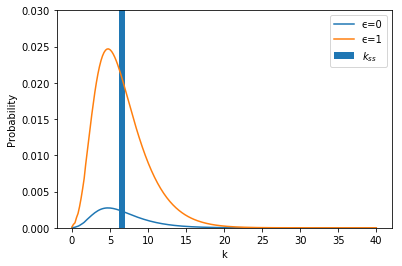

In [28]:
plt.plot(k_grid,μ[:nk],label='ϵ=0')
plt.plot(k_grid,μ[nk:],label='ϵ=1')
plt.bar(k_bar,.03,label=r'$k_{ss}$')
plt.ylim([0,0.03])
plt.xlabel('k')
plt.ylabel('Probability')
plt.legend()
plt.show()

Here we plot the capital policy functions for each $\epsilon$. We can see that for unemployed agents with low capital, they tend to save less capital due to the borrowing constraint.

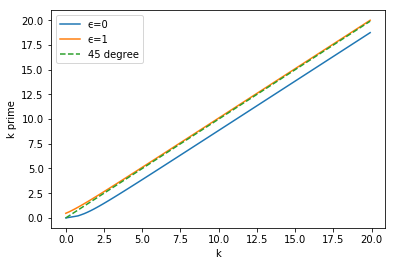

In [9]:
plt.plot(k_grid[:100],gk[:100],label='ϵ=0')
plt.plot(k_grid[:100],gk[nk:nk+100],label='ϵ=1')
plt.plot(k_grid[:100],k_grid[:100],'--',label='45 degree')
plt.xlabel('k')
plt.ylabel('k prime')
plt.legend()
plt.show()

In [10]:
k_grid_long = np.ones((nϵ,1)).dot(k_grid.reshape((1,nk))).reshape((nk*nϵ,1))
k_std = μ.dot(k_grid_long**2) - (μ.dot(k_grid_long))**2
coeff_of_var = k_std / k_bar
print('Coefficient of variation for capital is: %1.4f' % coeff_of_var)

Coefficient of variation for capital is: 1.7916
